# 6. 프로젝트: CAM을 만들고 평가해보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-1.max-800x600.png)

CAM(Class Activation Map)을 얻기 위한 방법 중 CAM, Grad-CAM을 구현해보고 시각화해보자.   
CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해보자.   
정답 데이터와 비교하기 위해 CAM으로 얻은 바운딩 박스와 실제 이미지가 갖고 있는 바운딩 박스를 이용해서 IoU를 사용하자.

CAM을 사용하기 위해 중요한 점은 해당 이미지가 분류 task여야 한다.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os
import copy

In [2]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.8.0
1.21.5
4.1.2
7.1.2


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. 데이터셋 준비하기

`tensorflow datasets`에서 `standford_dogs` 데이터셋을 사용하자.   
이는 120종의 개 사진을 판별하는 분류 문제 데이터셋으로, 바운딩 박스 정보를 포함하고 있다.

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

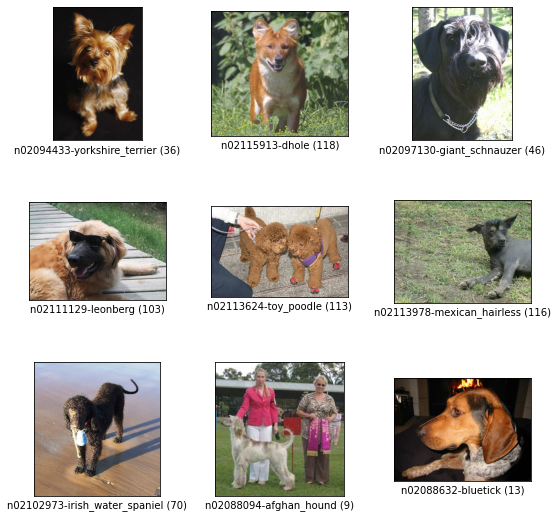

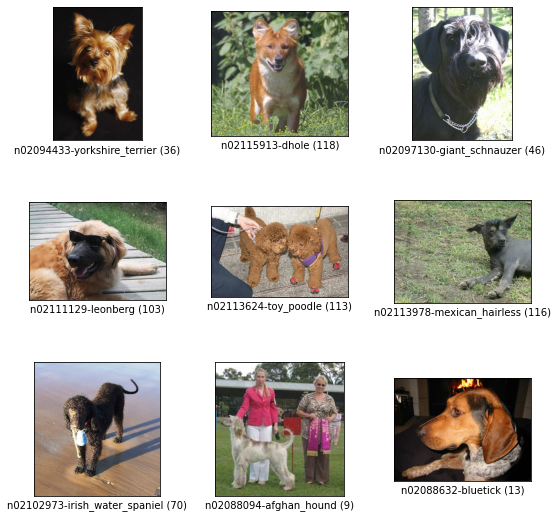

In [5]:
tfds.show_examples(ds_train, ds_info)

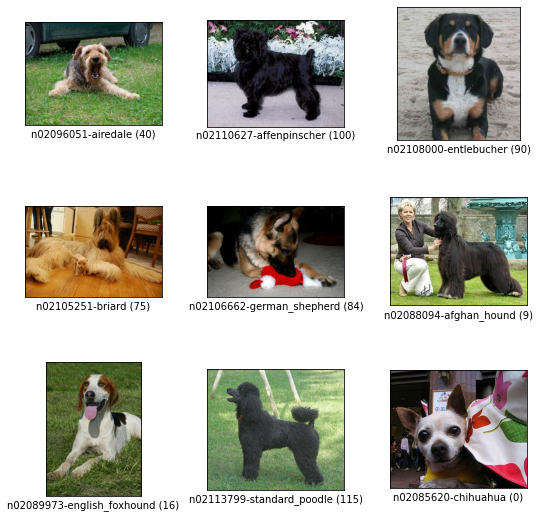

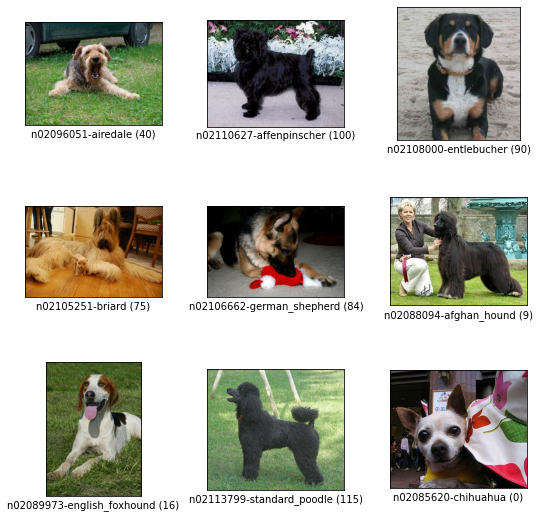

In [6]:
tfds.show_examples(ds_test, ds_info)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

위 결과를 보면 `objects`에 `bbox`가 있다. 이는 바운딩 박스를 말한다.

[tfds.features.BBox docs](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBox)를 보면 `BBox(ymin, xmin, ymax, xmax)` 로 표현되고 있음을 알 수 있다.

# 1-1. 모델 준비하기

ResNet50를 모델의 base로 두고, 여기에 GAP와 dense layer를 추가해서 준비하자.

이 모델은 CAM을 얻어내기 위한 모델로 사용한다.

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # resnet의 마지막 fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [9]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [10]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 전처리

In [11]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 전처리, 배치처리
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

### 모델 학습

In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 111s 127ms/step - loss: 2.1981 - accuracy: 0.4520 - val_loss: 3.3468 - val_accuracy: 0.2259
Epoch 2/10
750/750 [==============================] - 92s 123ms/step - loss: 0.6915 - accuracy: 0.8099 - val_loss: 1.0977 - val_accuracy: 0.6792
Epoch 3/10
750/750 [==============================] - 93s 123ms/step - loss: 0.2427 - accuracy: 0.9488 - val_loss: 0.9190 - val_accuracy: 0.7309
Epoch 4/10
750/750 [==============================] - 93s 124ms/step - loss: 0.0628 - accuracy: 0.9951 - val_loss: 0.9221 - val_accuracy: 0.7365
Epoch 5/10
750/750 [==============================] - 92s 123ms/step - loss: 0.0214 - accuracy: 0.9998 - val_loss: 0.9127 - val_accuracy: 0.7415
Epoch 6/10
750/750 [==============================] - 92s 123ms/step - loss: 0.0131 - accuracy: 0.9997 - val_loss: 0.9153 - val_accuracy: 0.7472
Epoch 7/10
750/750 [==============================] - 92s 123ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.9217 - val_a

In [13]:
# 저장하기
cam_model_path = '/content/drive/MyDrive/aiffel_dataset/make_CAM/cam_model1.h5'
cam_model.save(cam_model_path)
print("save")

# 불러오기
# cam_model_path = '/content/drive/MyDrive/aiffel_dataset/make_CAM/cam_model1.h5'
# cam_model = tf.keras.models.load_model(cam_model_path)
# print("load")

save


# 2. CAM 구현하기

### 2-1. get_one()
CAM 생성 작업은 개별 이미지 단위로 이루어진다.   
그래서 `get_one()` 함수를 만들어 데이터셋에서 한 장씩 뽑을 수 있게 만들자.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

40


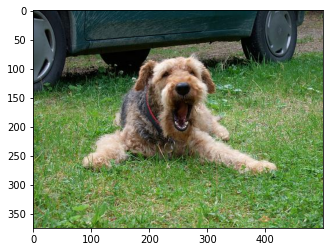

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

CAM을 생성하기 위해 필요한게 있다.   
- 특성 맵
- 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
- 원하는 클래스의 출력값

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 시각화해야 한다.   
이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.

In [16]:
def generate_cam(model, item):
    # get_one에서 뽑은 image인 item을 받는다.
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # model.layers[-3].output은 conv5_block3_out의 output값을 얻을 수 있다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))

    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] # 마지막 모델의 weight activation을 가져온다.

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산한다.
        cam_image += w * conv_outputs[:, :, i]


    cam_image /= np.max(cam_image) # activation score를 normalize한다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize한다.
    return cam_image

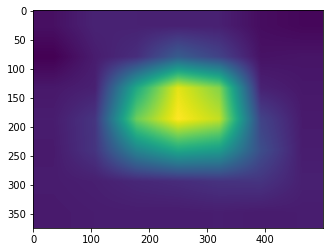

In [17]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [18]:
def visualize_cam_on_image(image, cam_image):
    alpha = 0.5
    beta = 1.0 - alpha

    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0)
    return merged_image

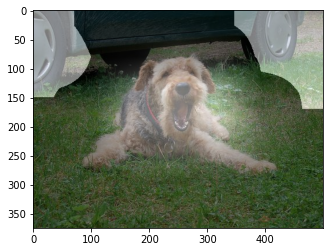

In [19]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# 3. Grad-CAM 구현하기

Grad-CAM은 모델을 구성하는 레이어와 정답 클래스에 대한 예측값 사이의 gradient를 GAP 연산을 적용함으로써 해당 레이어의 채널별 가중치를 구할 수 있다.

이러한 특성때문에 CAM 함수와 달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, gradient 계산을 원하는 관찰 대상 레이어 activation_layer를 받고 뽑아서 쓸 수 있도록 활용해야한다.

비교를 하기 위해 동일한 이미지로 Grad-CAM을 진행해보자.

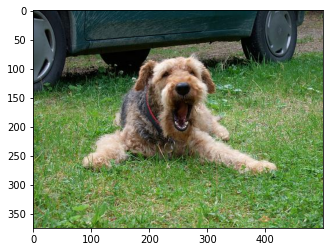

In [20]:
# item = get_one(ds_test)
# print(item['label'])
plt.imshow(item['image'])
plt.show()

In [21]:
def generate_grad_cam(model, activation_layer, item):
    # get_one에서 뽑은 image인 item을 받는다.
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # CAM과 달리 activation_layer를 통해 layer를 받는다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])


    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

cam_model.summary() 에서 나온 레이어의 이름을 토대로 CAM 이미지를 뽑아서 확인해보자.

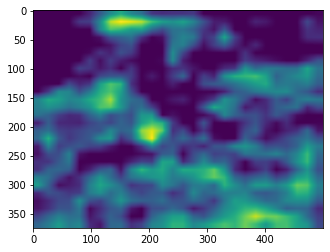

In [22]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)
plt.show()

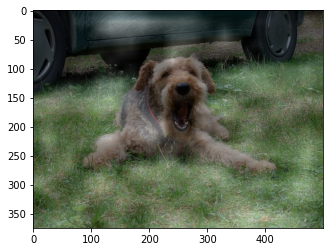

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

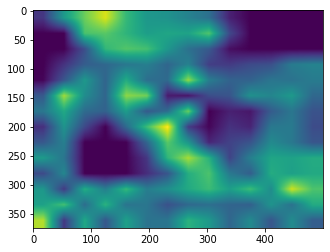

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)
plt.show()

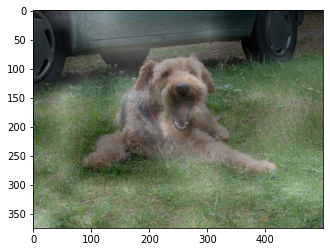

In [25]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

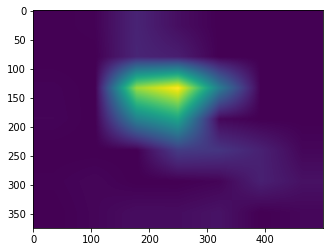

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

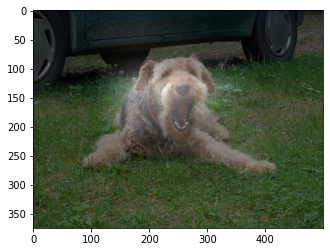

In [27]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# 4. 바운딩 박스 구하기

바운딩 박스를 추출할 이미지와 CAM, Grad-CAM으로 추출한 activation map을 갖고 bbox를 시각화해보자.

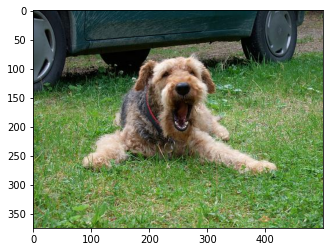

In [28]:
# item = get_one(ds_test)
# print(item['label'])
plt.imshow(item['image'])
plt.show()

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

### CAM

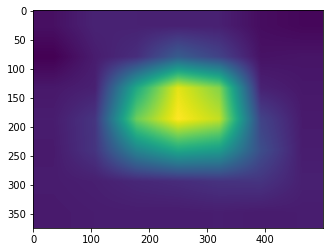

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [31]:
cam_rect = get_bbox(cam_image)
cam_rect

array([[430, 333],
       [ 61, 276],
       [103,   7],
       [472,  64]])

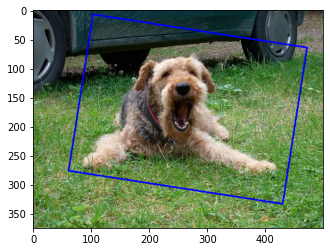

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [cam_rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Grad CAM

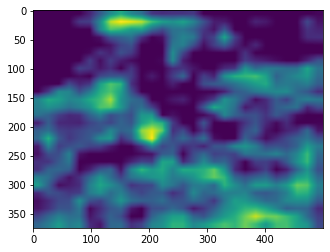

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block4_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [34]:
grad_cam_rect_1 = get_bbox(grad_cam_image)
grad_cam_rect_1

array([[375,  26],
       [375,  14],
       [405,  14],
       [405,  26]])

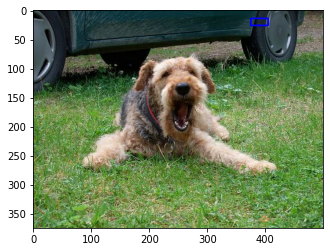

In [35]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_cam_rect_1], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

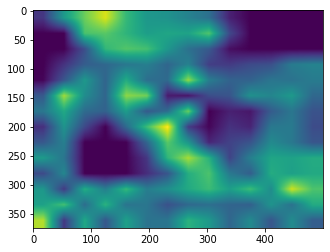

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [37]:
grad_cam_rect_2 = get_bbox(grad_cam_image)
grad_cam_rect_2

array([[499, 374],
       [  0, 374],
       [  0,   0],
       [499,   0]])

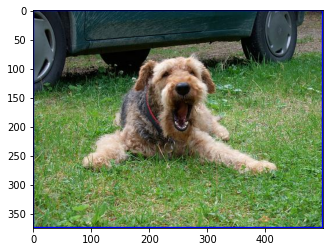

In [38]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_cam_rect_2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

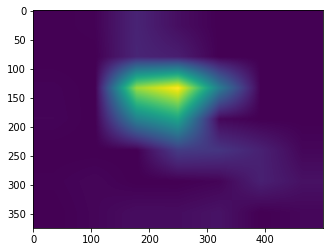

In [39]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [40]:
grad_cam_rect_3 = get_bbox(grad_cam_image)
grad_cam_rect_3

array([[444, 332],
       [ 76, 231],
       [146, -24],
       [514,  76]])

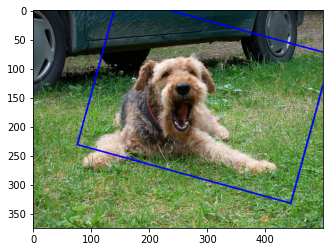

In [41]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [grad_cam_rect_3], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

Grad CAM의 bbox가 이상하게 나왔다. 그리고 마지막 레이어일수록 결과물이 괜찮아져 `conv5_block3_out`을 이용해서 IoU를 진행하자.

# 5. IoU 구하기

IoU(Intersection over Union)는 두 영역의 교집합 intersection 영역의 넓이를 두 영역의 합집합 union 영역으로 나누어준 값이다.   
이를 통해 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있고, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [42]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어진다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [43]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
cam_pred_bbox

[0.018666666666666668, 0.122, 0.888, 0.944]

In [44]:
# grad cam에서 가장 결과물이 좋은 conv5_block3_out로 확인해보자.
grad_cam_pred_bbox = rect_to_minmax(grad_cam_rect_3, item['image'])
grad_cam_pred_bbox

[-0.064, 0.152, 0.8853333333333333, 1.028]

In [45]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [46]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])


    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [47]:
get_iou(cam_pred_bbox, item['objects']['bbox'][0])

0.5325556133699976

In [48]:
get_iou(grad_cam_pred_bbox, item['objects']['bbox'][0])

0.4576150300971762

# 마무리

CAM과 Grad-CAM 둘 다 detection을 하기에는 좋지만 정확한 localization은 부족했다.   
IoU로 나온 결과를 보면 cam은 0.53, grad cam은 0.45가 나왔다.   

사람의 눈으로 결과물을 보았을 때 IoU와 비슷하게 Grad CAM보다 CAM의 bounding box 결과물이 더 좋았다. 하지만 0.5, 0.4가 나올정도로 detection이 잘못됐나? 싶기도 하다. grad cam이 비교적 유연한 대신 노이즈에 약한거 같다.

cam, grad-cam의 아이디어인 모델 레이어의 활성화 정도와 segmentation을 같이 사용했다면 더 좋은 결과물을 도출해낼 수 있지 않았을까? 